# Lab Course Structural Dynamics - LSD Tutorial
Notebook Tutorial: this notebook is intended to clarify the use of the functions 
in the LSD package. It uses the compiled version. This means, that all the functions 
are available and ready-to-use. However, the source code in not visible. The main purpose of this notebook is to show 
how the functions can be called to calculate and visualize results. 

The tasks (all of them can be found in the __task_notebook__) of this course can be separated in three groups:
- Source Code: Implement solver and preprocessing functions in Preprocessing.py and Solver.py 
- Application: Use the functions to answer further, comprehensive questions
- Documentation: Document your required theory, your results and answers in LSD Notebook 

The first task is already done here, so you can 
- Use it as reference for your implementation
- Get familiar with the function calls, visualization etc.
- Get familiar with the function inputs and outputs

 
## Content
- [Import Statements](#1)
- [Initialization and Preprocessing](#2)
- [Static Solution](#3)
- [Eigensolution](#4)
- [Harmonic Solution](#5)
- [Transient Solution](#6)

## Import Statements <a id='1'></a>

In this notebook the __LSDcompiled__ package is imported. The source code is not visible, but all functions are available. The source code that you are supposed to work on is located in the __LSD__ package. 

In [2]:
import os # Package to control operation system
import time # Time measurement
import numpy as np # Arrays and linear algebra
from matplotlib import pyplot as plt # Package for plots and visualization
import plotly.graph_objects as go
import inspect
working_path = os.getcwd();
# working_path = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# print(working_path)
# Change working path, otherwise the LSD packages cannot be found
os.chdir(working_path) 
# Import Preprocessing and Solver module from the LSDcompiled package
import LSDcompiled.Preprocessing  as Prep 
import LSDcompiled.Solver as Sol


Python was not able to load the fast fortran assembly routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element routines.
Python was not able to load the fast fortran element r

## Initialization and Preprocessing <a id='2'></a>

A finite element analysis is based on the geometry of a structure. In our case the geometry is defined by two pieces of information, which must be defined by the user:

- Keypoints in $\mathbb{R}^3$
- Lines that connect Keypoints.

The default lines and keypoints are already defined, they are stored as text files in the __Mesh__ folder.
Have a look at the text files to understand how they are defined and which information they contain in detail. 
Both files are passed to the __LineGeometry__ class of the Preprocessing module of the (compiled) LSD package.
Since the content of the text files is not commented, you can also have a look at the parsing routines
to further understand which information the files contain in detail. 

In [4]:
KeypointFile    = os.getcwd()+"/Mesh/HangarKeypoints.txt"
LineFile        = os.getcwd()+"/Mesh/HangarLines.txt"
HangarGeo = Prep.LineGeometry(KeypointFile,LineFile) # Class LineGeometry

Visualize the lines and keypoints to get a better intuition of the defined topology. The command
__%matplotlib__ opens the plots in a separate window. This allows you to rotate the visualization. 

In [5]:
%matplotlib 
HangarGeo.plotKeypoints()
HangarGeo.plotLines()

Using matplotlib backend: Qt5Agg


For a more compact documentation, plots which are located beneath the command might be desired. Use __%matplotlib inline__ to generate plots like that (again). Do not use both statements in the same cell - no figure will be displayed at all.  

In [6]:
%matplotlib inline

At this point, the topology of the to-be-analyzed structure is defined. But there are no finite elements yet. The generation 
of finite elements is typically connected with furhter discretization. Otherwise, the connection of two keypoints would be expressed by one line element. For many cases, this coarse discretization will not be sufficient. To depict the movement of the hangar accurately enough, the lines between the keypoints must further be discretized.

For the discretization, the number of nodes per line is defined. They associated property of the __LineGeometry__ class is __LineNodes__. Note that start and endpoint are included, this means that the minimum number is 2.

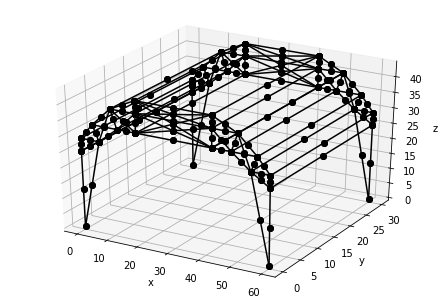

In [5]:
HangarGeo.LineNodes = [3] 
HangarGeo.discretizeLineGeometry()
HangarGeo.plotLineElements()

Setting __LineNodes = 3__ results in one additional point for each line (exactly in the middle). The further discretized lines are denoted as __LineElements__. You can visualize the default and discretized geometry. 

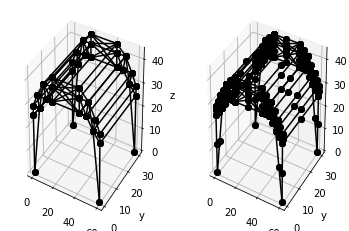

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
HangarGeo.plotLines(ax1)
HangarGeo.plotLineElements(ax2)

Based on the discretized geometry and material specifications, the mass and 
stiffness matrices can be generated. They are gathered in an object of the __MK__ class. Material properties are hard coded in the __assembleLineElements()__ function.

In [8]:
MKfree= HangarGeo.assembleLineElements() # MKfree is an MK class

In most cases, structures cannot move freely. Idealizing, fixed boundary conditions are applied to cetatin points. This means that not motion is allowed at all, the displacement, velocity and acceleration for translation and rotation are zero at any given time. 
Such boundary conditions can be defined for the desired degrees of freedom. Commonly, boundary conditions are associated with certain locations of the structure. This means that the degrees of freedom which are associated with this position, must be acquired. This can be achieved via the __Map()__ property of the __MK__ class. 

Fixing all dofs of the point $[0,0,0]$ can be achieved like this:

In [9]:
Coords = np.array([[0,0,0]]) # Define a point in 3D, two points: np.array([[0,0,0],[0,0,0]])
fixDof, freeDof = MKfree.Map.getByCoords(Coords) # Get the associated, and not dof

MKfix = MKfree.truncate(fixDof) # Fix the structure on these dof
# print(MKfix.M)

Note that the function __getByCoords()__ also returns the complementary degrees of freedom. This method applies the fixed boundary conditions to the mass and stiffness matrix. 

Typically, a fixed structure is the basis for further analysis since many practical application assume fixed boundary conditions. This analysis can be static, modal, harmonic or transient. Each type requires certain solvers, to obtain the desired information. The __Solver()__ class of the same-named module contains all the required solution procedures. 
The required input is a mass and stiffness matrix. 

In [11]:
SolverFix = Sol.Solver(MKfix.M,MKfix.K) 

For some tasks, the maipulation of the definition of the given structure might be required. To give you an intuition how this can look like, a different version of the hangar is defined. It contains several additional beams. It can be loaded, visualized and discretize equivalently. 

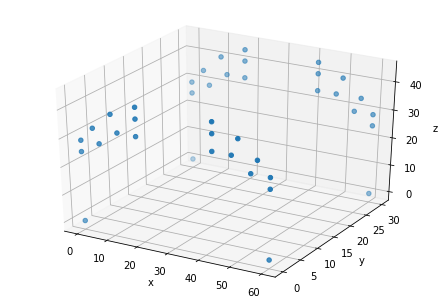

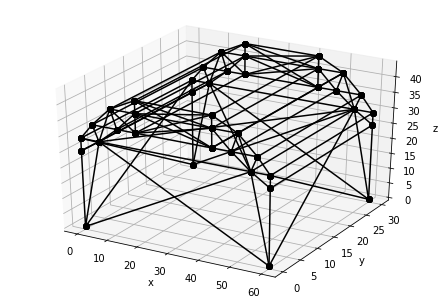

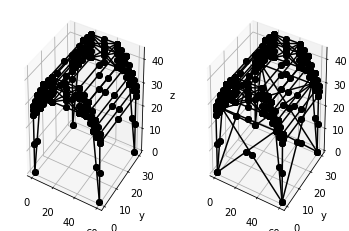

In [12]:
KeypointFile    = os.getcwd()+"/Mesh/HangarKeypoints.txt"
LineFile        = os.getcwd()+"/Mesh/HangarLinesAddedBeam.txt"
HangarGeoAddedBeams = Prep.LineGeometry(KeypointFile,LineFile)

HangarGeoAddedBeams.plotKeypoints()
HangarGeoAddedBeams.plotLines()
HangarGeoAddedBeams.LineNodes = [3]
HangarGeoAddedBeams.discretizeLineGeometry()

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
HangarGeo.plotLineElements(ax1)
HangarGeoAddedBeams.plotLineElements(ax2)

## Static Solution <a id='3'></a>

In case only steady-state defelction are of interest, the static solution is desired. A static analysis requires a right-hand-side load vector. The definition of the load vector is similar to the definition of boundary conditions. At first a point in 3D where the force is exerted is defined. The degrees of freedom, in this case only in x-direction, are extracted from the map. The load vector is zero except for the defined load dof and accordingly initialized. Sign and magnitude of the load dof can be defined and assigned to the particular entry. 

In [18]:
loadCoords = np.array([[18,0, 44]])
loadDof,_ = MKfix.Map.getByCoords(loadCoords,'x')
LoadExt = np.zeros(MKfix.Map.DofNumber()) # initialize LoadExt to the dimension of freedof
LoadExt[loadDof] = [-3] # define the sign and magnitude of the load, coule be an array here
# LoadExt[[2,3]] = [1,-3] # array example to define sign and magnitude of the load
# print(LoadExt)

The load vector can be passed to the static solution. The solution can be obtained by computing the entire inverse or by factorization of the stiffness matrix. The output of the __Inverse()__ and __Factorization()__ method of the __StaticSolver()__
class are the deflection as well as offline and online computation time. 

In [14]:
sResI,tOffI,tOnI = SolverFix.Static.Inverse(load = LoadExt)
sResF,tOffF,tOnF = SolverFix.Static.Factorization(load = LoadExt)

/home/jimmyyang/PSD/Student Template/LSDcompiled/Solver.py:38: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/home/jimmyyang/anaconda3/envs/PSD/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning:

splu requires CSC matrix format

/home/jimmyyang/anaconda3/envs/PSD/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:203: SparseEfficiencyWarning:

spsolve is more efficient when sparse b is in the CSC matrix format

/home/jimmyyang/PSD/Student Template/LSDcompiled/Solver.py:81: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



The static displacement can be visualized using the __plotDisplacementLine()__ method of the __LineGeometry__ class. 
Note that the displacement for a fixed structure is only defined for the degrees of freedom which are still allowed to move. 
However, the displacement plot expects a displacement which is defined for the entire geometry. To map the fixed to the full displacement, a matrix can be used which is stored as __R__ property of the __MK__ class. Converting from fixed to full resolution can simply be achieved by matrix multiplication. The displacement is depicted in <font color='DarkRed'> DarkRed</font>.

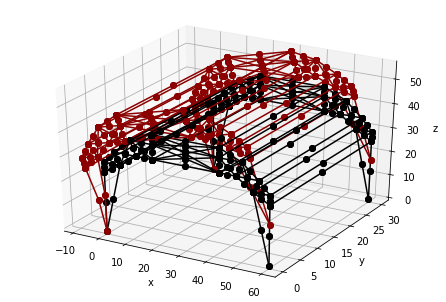

In [15]:
HangarGeo.plotDisplacementLine(MKfix.R@sResF)

## Eigensolution <a id='4'></a>

Eigensolutions are fundamental motions of a structure, which consist of a shape and a frequency. Compared to the static solution, no right hand side is invovled. This also reflects the term 'eigen' which means that these motions are a property of the structure itself and do not depent on any external forcing terms. The fundamental equation to-be-solved is 

$(K-M\omega ^2)\Phi$ = 0 

Commonly, this equation can be solved by as many pairs of eigenfrequencies $\omega_i$ and eigenshapes $\Phi_i$ as number of degrees of freedom in the system. One possibility to solve the equation is to use an off-the-shelf eigensolver from the python scipy.sparse package. This is already implemented in the __ScipySparse()__ method of the __EigenSolver__ class. Note that calculating all eigenmodes is commonly not required and would be computationally very demanding. Therefore, the number of desired eigenmodes is requried as input argument. The eigenmodes are calculated statring with the lowest frequency, except a so called shift is defined. The first then eigenmodes can be calculated by: 

In [16]:
omegaFix, modesFix = SolverFix.Eigen.ScipySparse(10)

The resulting eigenfrequencies and eigenshapes can be visualized.

In [22]:
%matplotlib 
fig = plt.figure()
plt.plot(omegaFix,label="All")    
plt.legend()


fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

HangarGeo.plotDisplacementLine(MKfix.R @ modesFix[:,0],axis=ax1)
HangarGeo.plotDisplacementLine(MKfix.R @ modesFix[:,1],axis=ax2)
HangarGeo.plotDisplacementLine(MKfix.R @ modesFix[:,2],axis=ax3)

Using matplotlib backend: Qt5Agg


Besides the eigensolver from the scipy package, the __to-be-implemented__
Power Iteration and Krylov Subspace solver can be used. 

In [19]:
%matplotlib inline
omegaSP, modesSP = SolverFix.Eigen.ScipySparse(10)
omegaPI, modesPI = SolverFix.Eigen.PowerIteration(10)
omegaKS, modesKS = SolverFix.Eigen.KrylovSubspace(10)

## Harmonic Solution <a id='5'></a>

In case the load on the structure is a harmonic load, the structure's response 
is harmonic, too. Therefore, the response can be expressed as an amplitude and
phase. Both quantities are defined with respect to the forcing term. The evaluation of this relation 
over a specified frequency range is the harmonic response of the structure.

The harmonic response can be calculated directly, by inversion.
Alternatively, modes can be used which is computationally more efficient.
The modal superposition can be improved by including static information. 
This is called Mode Acceleration method. All these methods can be evaluated like: 

In [17]:
frequency_axis = np.linspace(0,3,100)

[hValD, wValD]   = SolverFix.Harmonic.DirectHarmonics(frequency_axis)
[hValMT, wValMT] = SolverFix.Harmonic.ModalSuperposition(frequency_axis)
[hValMA, wValMA] = SolverFix.Harmonic.ModeAcceleration(frequency_axis)

/home/jimmyyang/PSD/Student Template/LSDcompiled/Solver.py:519: ComplexWarning:

Casting complex values to real discards the imaginary part

/home/jimmyyang/PSD/Student Template/LSDcompiled/Solver.py:541: ComplexWarning:

Casting complex values to real discards the imaginary part



The amplitude of the harmonic response can be visualized. 
The harmonic response (also frequency response) is a __3 dimensional complex array Y__ since the relation from all inputs to all outputs is evaluated over a certain freqeuncy axis - resulting in 

$ Y \in \mathbb{C}^{out \times in \times freq}$.

Therefore, plots are typically defined for certain in- and outputs. These dof can also be specified via 3D point + direction (see boundary condition + static solution)! Note that harmonic response amplitude is typically plotted on a logarithmic scale.
Otherwise anti-resonances are not visible. 

In [ ]:
%matplotlib
output_dof = 1
input_dof  = 1

fig = go.Figure()
fig.add_trace(go.Scatter(x=frequency_axis, y=np.abs(hValD[output_dof,input_dof,:]), mode='lines',name = 'Direct Harmonics')) 
fig.add_trace(go.Scatter(x=frequency_axis,y=np.abs(hValMT[output_dof,input_dof,:]), mode='lines',name = 'Mode Superposition')) 
fig.add_trace(go.Scatter(x=frequency_axis,y=np.abs(hValMA[output_dof,input_dof,:]), mode='lines+markers',name = 'Mode Acceleration')) 
fig.update_layout( yaxis_type="log")
fig.show()


## Transient Solution <a id='6'></a>

Transient solutions are required if the forcing function is truly time dependent. This means it is non-static and not periodic. In these cases, specialized solution strategies are already discussed. 

The transient analysis is the numerical solution of a second order differential equation. There are three reason why a movement occurs: 
- A forcing term on the right hand side
- A non-zero initial condition
- Both

For the first one, the start is to define the load dof. The all flag 'all' returns all dof of the specifed point.
The transient solution is specified on a time series. This time series is defined by the user. In this course, a constant time step __deltaT__ is assumed. Additionally, the total time __totalT__ is defined.
 
With this informations, the load can be defined. The function  __createLoad()__ can be used to do this. The resuling forcing terms can be visualized.  

In [ ]:
loadCoords = np.array([[18,0, 44]])
loadDof,_ = MKfix.Map.getByCoords(loadCoords,'all')

deltaT = 1e-2
totalT = 1

AMload,AMtime = SolverFix.Transient.createLoad(totalT,loadDof,Mag=100,Type = 'AM',deltaT=deltaT)
AMloadLong,AMtimeLong = SolverFix.Transient.createLoad(totalT,loadDof,Mag=100,Type = 'AMlong',deltaT=deltaT)
Load,Time = SolverFix.Transient.createLoad(totalT,loadDof,Mag=1,deltaT=deltaT)

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.plot(AMtimeLong ,AMloadLong[loadDof[1],:],label="AMlong") 
ax1.plot(AMtime ,AMload[loadDof[1],:],label="AM") 
ax2.plot(Time ,Load[loadDof[1],:],label="Rect") 
ax1.legend()
ax2.legend()

fig = go.Figure()
fig.add_trace(go.Scatter(x= Time, y=AMloadLong[loadDof[1],:], mode='lines',name = 'AM long'))
fig.add_trace(go.Scatter(x= Time, y=AMload[loadDof[1],:], mode='lines',name = 'AM'))
fig.add_trace(go.Scatter(x= Time, y=Load[loadDof[1],:], mode='lines',name = 'Rect'))
fig.show()


In this example, the initial conditions are set to zero. The __Newmark Integration__ scheme allows to perform several different 
integration procedures by changing two parameters. The transient solver class includes the interfaces to all these procedures. Note that there are different stability limits, which depend on the size of the time step!

In [ ]:
x0 = np.zeros(MKfix.Map.DofNumber())
dx0 = np.zeros(MKfix.Map.DofNumber())

xAA, _, _  = SolverFix.Transient.AverageConstantAcceleration(x0,dx0,Load,Time)
xCD, _, _  = SolverFix.Transient.CentralDifference(x0,dx0,Load,Time)
xFG, _, _  = SolverFix.Transient.Fox_N_Goodwin(x0,dx0,Load,Time)
xLA, _, _  = SolverFix.Transient.LinearAcceleration(x0,dx0,Load,Time)
xPE, _, _  = SolverFix.Transient.PurelyExplicit(x0,dx0,Load,Time)

The instability can be clearly observed. 

In [ ]:
HangarGeo.plotDisplacementLine(MKfix.R@xAA[:,1])

fig = plt.figure()
plt.plot(Time ,xAA[4,:],label="Average Constant Acceleration") 
plt.plot(Time ,xCD[4,:],label="Central Difference") 
plt.plot(Time ,xFG[4,:],label="Fox And Goodwin") 
plt.plot(Time ,xLA[4,:],label="Linear Acceleration") 
plt.plot(Time ,xPE[4,:],label="Purely Explicit") 
plt.legend()


fig = go.Figure()
fig.add_trace(go.Scatter(x= Time, y=xAA[4,:], mode='lines',name = 'Average Constant Acceleration'))
fig.add_trace(go.Scatter(x= Time, y=xCD[4,:], mode='lines',name = 'Central Difference'))
fig.add_trace(go.Scatter(x= Time, y=xFG[4,:], mode='lines',name = 'Fox And Goodwin'))
fig.add_trace(go.Scatter(x= Time, y=xLA[4,:], mode='lines',name = 'Linear Acceleration'))
fig.add_trace(go.Scatter(x= Time, y=xPE[4,:], mode='lines',name = 'Purely Explicit'))
fig.show()



In contrast to eigen- and harmonic solver (except direct harmonics), __arbitrary__ damping can be easily included in the transient solution. The provided interface supports coefficients a and b for structural damping (this could also be regarded in eigensolvers). An example is given below. The damped and undamped solution of the Average Constant Acceleration method is visualized: 

In [ ]:
a = 0.0001184
b = 0.002029

xAAd, _, _  = SolverFix.Transient.AverageConstantAcceleration(x0,dx0,Load,Time,a,b)
plotted_dof = 4


fig = go.Figure()
fig.add_trace(go.Scatter(x= Time, y=xAA[4,:], mode='lines',name = 'Undamped')) 
fig.add_trace(go.Scatter(x= Time, y=xAAd[4,:], mode='lines',name = 'Damped')) 
fig.show()

